In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [28]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\UbidelAcet_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.002
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [29]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [30]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [31]:
batch_size=256

In [32]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [33]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [34]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [35]:
prediction_result_cv = []
prediction_result_ind = []

In [36]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet')

In [37]:
out = os.getcwd() + '\\'

In [38]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  


Epoch 00026: val_loss did not improve from 0.57503
Epoch 27/300
8/8 - 0s - loss: 0.4584 - accuracy: 0.7756 - val_loss: 0.6059 - val_accuracy: 0.6267

Epoch 00027: val_loss did not improve from 0.57503
Epoch 28/300
8/8 - 0s - loss: 0.5153 - accuracy: 0.7558 - val_loss: 0.6023 - val_accuracy: 0.6622

Epoch 00028: val_loss did not improve from 0.57503
Epoch 29/300
8/8 - 0s - loss: 0.4453 - accuracy: 0.7865 - val_loss: 0.5707 - val_accuracy: 0.6578

Epoch 00029: val_loss improved from 0.57503 to 0.57067, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_0.h5
Epoch 30/300
8/8 - 0s - loss: 0.4646 - accuracy: 0.7746 - val_loss: 0.5950 - val_accuracy: 0.6444

Epoch 00030: val_loss did not improve from 0.57067
Epoch 31/300
8/8 - 0s - loss: 0.5013 - accuracy: 0.7548 - val_loss: 0.5850 - val_accuracy: 0.6800

Epoch 00031: val_loss did not improve from 0.57067
Epoch 32/300
8/8 - 0s - loss: 0.4324 - accuracy: 0.79


Epoch 00075: val_loss did not improve from 0.54767
Epoch 76/300
8/8 - 0s - loss: 0.2607 - accuracy: 0.8932 - val_loss: 0.6255 - val_accuracy: 0.6711

Epoch 00076: val_loss did not improve from 0.54767
Epoch 77/300
8/8 - 0s - loss: 0.2985 - accuracy: 0.8680 - val_loss: 0.6395 - val_accuracy: 0.6667

Epoch 00077: val_loss did not improve from 0.54767
Epoch 78/300
8/8 - 0s - loss: 0.2829 - accuracy: 0.8828 - val_loss: 0.5848 - val_accuracy: 0.6889

Epoch 00078: val_loss did not improve from 0.54767
Epoch 79/300
8/8 - 0s - loss: 0.2870 - accuracy: 0.8799 - val_loss: 0.5767 - val_accuracy: 0.6667

Epoch 00079: val_loss did not improve from 0.54767
Epoch 80/300
8/8 - 0s - loss: 0.2936 - accuracy: 0.8789 - val_loss: 0.6172 - val_accuracy: 0.6622

Epoch 00080: val_loss did not improve from 0.54767
Epoch 81/300
8/8 - 0s - loss: 0.2601 - accuracy: 0.8913 - val_loss: 0.5695 - val_accuracy: 0.7022

Epoch 00081: val_loss did not improve from 0.54767
Epoch 82/300
8/8 - 0s - loss: 0.2877 - accuracy:

8/8 - 1s - loss: 0.6770 - accuracy: 0.5699 - val_loss: 0.6510 - val_accuracy: 0.6889

Epoch 00001: val_loss improved from inf to 0.65098, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_1.h5
Epoch 2/300
8/8 - 0s - loss: 0.6487 - accuracy: 0.6055 - val_loss: 0.6191 - val_accuracy: 0.7022

Epoch 00002: val_loss improved from 0.65098 to 0.61913, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_1.h5
Epoch 3/300
8/8 - 0s - loss: 0.6262 - accuracy: 0.6451 - val_loss: 0.6128 - val_accuracy: 0.6533

Epoch 00003: val_loss improved from 0.61913 to 0.61278, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_1.h5
Epoch 4/300
8/8 - 0s - loss: 0.6178 - accuracy: 0.6490 - val_loss: 0.5986 - val_accuracy: 0.7067

Epoch 00004: val_loss improved from 


Epoch 00041: val_loss did not improve from 0.52477
Epoch 42/300
8/8 - 0s - loss: 0.3953 - accuracy: 0.8309 - val_loss: 0.5188 - val_accuracy: 0.7644

Epoch 00042: val_loss improved from 0.52477 to 0.51879, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_1.h5
Epoch 43/300
8/8 - 0s - loss: 0.4623 - accuracy: 0.7776 - val_loss: 0.5471 - val_accuracy: 0.7422

Epoch 00043: val_loss did not improve from 0.51879
Epoch 44/300
8/8 - 0s - loss: 0.4044 - accuracy: 0.8127 - val_loss: 0.5414 - val_accuracy: 0.7111

Epoch 00044: val_loss did not improve from 0.51879
Epoch 45/300
8/8 - 0s - loss: 0.4308 - accuracy: 0.8057 - val_loss: 0.5339 - val_accuracy: 0.7556

Epoch 00045: val_loss did not improve from 0.51879
Epoch 46/300
8/8 - 0s - loss: 0.4219 - accuracy: 0.8023 - val_loss: 0.5495 - val_accuracy: 0.7689

Epoch 00046: val_loss did not improve from 0.51879
Epoch 47/300
8/8 - 0s - loss: 0.4076 - accuracy: 0.81


Epoch 00093: val_loss did not improve from 0.51381
Epoch 94/300
8/8 - 0s - loss: 0.2809 - accuracy: 0.8789 - val_loss: 0.5514 - val_accuracy: 0.7422

Epoch 00094: val_loss did not improve from 0.51381
Epoch 95/300
8/8 - 0s - loss: 0.2643 - accuracy: 0.8878 - val_loss: 0.5423 - val_accuracy: 0.7156

Epoch 00095: val_loss did not improve from 0.51381
Epoch 96/300
8/8 - 0s - loss: 0.2236 - accuracy: 0.9140 - val_loss: 0.5569 - val_accuracy: 0.7022

Epoch 00096: val_loss did not improve from 0.51381
Epoch 97/300
8/8 - 0s - loss: 0.3048 - accuracy: 0.8720 - val_loss: 0.5318 - val_accuracy: 0.7244

Epoch 00097: val_loss did not improve from 0.51381
Epoch 98/300
8/8 - 0s - loss: 0.2156 - accuracy: 0.9100 - val_loss: 0.5322 - val_accuracy: 0.7333

Epoch 00098: val_loss did not improve from 0.51381
Epoch 99/300
8/8 - 0s - loss: 0.2951 - accuracy: 0.8799 - val_loss: 0.5337 - val_accuracy: 0.7200

Epoch 00099: val_loss did not improve from 0.51381
Epoch 100/300
8/8 - 0s - loss: 0.2109 - accuracy


Epoch 00011: val_loss improved from 0.55946 to 0.55019, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_2.h5
Epoch 12/300
8/8 - 0s - loss: 0.5553 - accuracy: 0.7128 - val_loss: 0.5654 - val_accuracy: 0.7467

Epoch 00012: val_loss did not improve from 0.55019
Epoch 13/300
8/8 - 0s - loss: 0.5464 - accuracy: 0.7187 - val_loss: 0.5525 - val_accuracy: 0.7422

Epoch 00013: val_loss did not improve from 0.55019
Epoch 14/300
8/8 - 0s - loss: 0.5650 - accuracy: 0.7059 - val_loss: 0.5540 - val_accuracy: 0.7511

Epoch 00014: val_loss did not improve from 0.55019
Epoch 15/300
8/8 - 0s - loss: 0.5294 - accuracy: 0.7237 - val_loss: 0.5869 - val_accuracy: 0.6889

Epoch 00015: val_loss did not improve from 0.55019
Epoch 16/300
8/8 - 0s - loss: 0.5659 - accuracy: 0.6950 - val_loss: 0.5537 - val_accuracy: 0.7556

Epoch 00016: val_loss did not improve from 0.55019
Epoch 17/300
8/8 - 0s - loss: 0.5535 - accuracy: 0.70


Epoch 00057: val_loss did not improve from 0.48114
Epoch 58/300
8/8 - 0s - loss: 0.3825 - accuracy: 0.8230 - val_loss: 0.4988 - val_accuracy: 0.7600

Epoch 00058: val_loss did not improve from 0.48114
Epoch 59/300
8/8 - 0s - loss: 0.3175 - accuracy: 0.8685 - val_loss: 0.4923 - val_accuracy: 0.7644

Epoch 00059: val_loss did not improve from 0.48114
Epoch 60/300
8/8 - 0s - loss: 0.3509 - accuracy: 0.8334 - val_loss: 0.5007 - val_accuracy: 0.7733

Epoch 00060: val_loss did not improve from 0.48114
Epoch 61/300
8/8 - 0s - loss: 0.3667 - accuracy: 0.8285 - val_loss: 0.4819 - val_accuracy: 0.7867

Epoch 00061: val_loss did not improve from 0.48114
Epoch 62/300
8/8 - 0s - loss: 0.3628 - accuracy: 0.8398 - val_loss: 0.4908 - val_accuracy: 0.7733

Epoch 00062: val_loss did not improve from 0.48114
Epoch 63/300
8/8 - 0s - loss: 0.3330 - accuracy: 0.8532 - val_loss: 0.5131 - val_accuracy: 0.7556

Epoch 00063: val_loss did not improve from 0.48114
Epoch 64/300
8/8 - 0s - loss: 0.3511 - accuracy:


Epoch 00108: val_loss did not improve from 0.47679
Epoch 109/300
8/8 - 0s - loss: 0.1994 - accuracy: 0.9204 - val_loss: 0.5413 - val_accuracy: 0.7289

Epoch 00109: val_loss did not improve from 0.47679
Epoch 110/300
8/8 - 0s - loss: 0.2380 - accuracy: 0.8962 - val_loss: 0.5523 - val_accuracy: 0.7022

Epoch 00110: val_loss did not improve from 0.47679
Epoch 111/300
8/8 - 0s - loss: 0.2419 - accuracy: 0.8992 - val_loss: 0.5260 - val_accuracy: 0.7378

Epoch 00111: val_loss did not improve from 0.47679
Epoch 112/300
8/8 - 0s - loss: 0.2290 - accuracy: 0.9031 - val_loss: 0.5209 - val_accuracy: 0.7333

Epoch 00112: val_loss did not improve from 0.47679
Epoch 113/300
8/8 - 0s - loss: 0.1985 - accuracy: 0.9184 - val_loss: 0.5059 - val_accuracy: 0.7556

Epoch 00113: val_loss did not improve from 0.47679
Epoch 114/300
8/8 - 0s - loss: 0.3236 - accuracy: 0.8680 - val_loss: 0.5189 - val_accuracy: 0.7333

Epoch 00114: val_loss did not improve from 0.47679
Epoch 115/300
8/8 - 0s - loss: 0.2073 - ac

8/8 - 0s - loss: 0.6120 - accuracy: 0.6441 - val_loss: 0.6397 - val_accuracy: 0.6222

Epoch 00004: val_loss did not improve from 0.62885
Epoch 5/300
8/8 - 0s - loss: 0.6052 - accuracy: 0.6629 - val_loss: 0.6225 - val_accuracy: 0.6667

Epoch 00005: val_loss improved from 0.62885 to 0.62250, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_3.h5
Epoch 6/300
8/8 - 0s - loss: 0.5899 - accuracy: 0.6831 - val_loss: 0.6449 - val_accuracy: 0.5911

Epoch 00006: val_loss did not improve from 0.62250
Epoch 7/300
8/8 - 0s - loss: 0.5796 - accuracy: 0.6925 - val_loss: 0.6128 - val_accuracy: 0.6889

Epoch 00007: val_loss improved from 0.62250 to 0.61276, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_3.h5
Epoch 8/300
8/8 - 0s - loss: 0.5696 - accuracy: 0.6980 - val_loss: 0.6149 - val_accuracy: 0.6667

Epoch 00008: val_loss did no


Epoch 00044: val_loss improved from 0.56696 to 0.56291, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_3.h5
Epoch 45/300
8/8 - 0s - loss: 0.4525 - accuracy: 0.7870 - val_loss: 0.5700 - val_accuracy: 0.6978

Epoch 00045: val_loss did not improve from 0.56291
Epoch 46/300
8/8 - 0s - loss: 0.3935 - accuracy: 0.8211 - val_loss: 0.5805 - val_accuracy: 0.6844

Epoch 00046: val_loss did not improve from 0.56291
Epoch 47/300
8/8 - 0s - loss: 0.4563 - accuracy: 0.7874 - val_loss: 0.5813 - val_accuracy: 0.7200

Epoch 00047: val_loss did not improve from 0.56291
Epoch 48/300
8/8 - 0s - loss: 0.3746 - accuracy: 0.8280 - val_loss: 0.6062 - val_accuracy: 0.6800

Epoch 00048: val_loss did not improve from 0.56291
Epoch 49/300
8/8 - 0s - loss: 0.3918 - accuracy: 0.8191 - val_loss: 0.5869 - val_accuracy: 0.7022

Epoch 00049: val_loss did not improve from 0.56291
Epoch 50/300
8/8 - 0s - loss: 0.3953 - accuracy: 0.82


Epoch 00097: val_loss did not improve from 0.56116
Epoch 98/300
8/8 - 0s - loss: 0.2499 - accuracy: 0.8927 - val_loss: 0.5677 - val_accuracy: 0.6933

Epoch 00098: val_loss did not improve from 0.56116
Epoch 99/300
8/8 - 0s - loss: 0.2497 - accuracy: 0.8957 - val_loss: 0.5840 - val_accuracy: 0.7022

Epoch 00099: val_loss did not improve from 0.56116
Epoch 100/300
8/8 - 0s - loss: 0.2444 - accuracy: 0.9066 - val_loss: 0.6096 - val_accuracy: 0.7022

Epoch 00100: val_loss did not improve from 0.56116
Epoch 101/300
8/8 - 0s - loss: 0.2314 - accuracy: 0.9046 - val_loss: 0.6414 - val_accuracy: 0.6933

Epoch 00101: val_loss did not improve from 0.56116
Epoch 102/300
8/8 - 0s - loss: 0.2932 - accuracy: 0.8715 - val_loss: 0.5853 - val_accuracy: 0.6978

Epoch 00102: val_loss did not improve from 0.56116
Epoch 103/300
8/8 - 0s - loss: 0.1919 - accuracy: 0.9283 - val_loss: 0.5879 - val_accuracy: 0.6711

Epoch 00103: val_loss did not improve from 0.56116
Epoch 104/300
8/8 - 0s - loss: 0.2337 - accu


Epoch 00009: val_loss improved from 0.57788 to 0.55738, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_4.h5
Epoch 10/300
8/8 - 0s - loss: 0.5698 - accuracy: 0.6965 - val_loss: 0.5751 - val_accuracy: 0.6756

Epoch 00010: val_loss did not improve from 0.55738
Epoch 11/300
8/8 - 0s - loss: 0.6107 - accuracy: 0.6624 - val_loss: 0.5706 - val_accuracy: 0.7422

Epoch 00011: val_loss did not improve from 0.55738
Epoch 12/300
8/8 - 0s - loss: 0.5563 - accuracy: 0.7123 - val_loss: 0.5755 - val_accuracy: 0.6800

Epoch 00012: val_loss did not improve from 0.55738
Epoch 13/300
8/8 - 0s - loss: 0.5435 - accuracy: 0.7182 - val_loss: 0.5594 - val_accuracy: 0.7067

Epoch 00013: val_loss did not improve from 0.55738
Epoch 14/300
8/8 - 0s - loss: 0.5675 - accuracy: 0.7079 - val_loss: 0.5627 - val_accuracy: 0.7333

Epoch 00014: val_loss did not improve from 0.55738
Epoch 15/300
8/8 - 0s - loss: 0.5533 - accuracy: 0.70


Epoch 00055: val_loss did not improve from 0.50032
Epoch 56/300
8/8 - 0s - loss: 0.3742 - accuracy: 0.8280 - val_loss: 0.5128 - val_accuracy: 0.7467

Epoch 00056: val_loss did not improve from 0.50032
Epoch 57/300
8/8 - 0s - loss: 0.3985 - accuracy: 0.8176 - val_loss: 0.5279 - val_accuracy: 0.6800

Epoch 00057: val_loss did not improve from 0.50032
Epoch 58/300
8/8 - 0s - loss: 0.3361 - accuracy: 0.8522 - val_loss: 0.5073 - val_accuracy: 0.7111

Epoch 00058: val_loss did not improve from 0.50032
Epoch 59/300
8/8 - 0s - loss: 0.4066 - accuracy: 0.8131 - val_loss: 0.5114 - val_accuracy: 0.7244

Epoch 00059: val_loss did not improve from 0.50032
Epoch 60/300
8/8 - 0s - loss: 0.3808 - accuracy: 0.8290 - val_loss: 0.5099 - val_accuracy: 0.7067

Epoch 00060: val_loss did not improve from 0.50032
Epoch 61/300
8/8 - 0s - loss: 0.3637 - accuracy: 0.8413 - val_loss: 0.6298 - val_accuracy: 0.6844

Epoch 00061: val_loss did not improve from 0.50032
Epoch 62/300
8/8 - 0s - loss: 0.3615 - accuracy:


Epoch 00108: val_loss did not improve from 0.48790
Epoch 109/300
8/8 - 0s - loss: 0.2058 - accuracy: 0.9150 - val_loss: 0.5096 - val_accuracy: 0.7200

Epoch 00109: val_loss did not improve from 0.48790
Epoch 110/300
8/8 - 0s - loss: 0.2561 - accuracy: 0.8873 - val_loss: 0.5401 - val_accuracy: 0.6889

Epoch 00110: val_loss did not improve from 0.48790
Epoch 111/300
8/8 - 0s - loss: 0.2303 - accuracy: 0.9066 - val_loss: 0.5376 - val_accuracy: 0.6844

Epoch 00111: val_loss did not improve from 0.48790
Epoch 112/300
8/8 - 0s - loss: 0.2378 - accuracy: 0.9001 - val_loss: 0.4968 - val_accuracy: 0.7333

Epoch 00112: val_loss did not improve from 0.48790
Epoch 113/300
8/8 - 0s - loss: 0.2145 - accuracy: 0.9150 - val_loss: 0.5183 - val_accuracy: 0.7422

Epoch 00113: val_loss did not improve from 0.48790
Epoch 114/300
8/8 - 0s - loss: 0.2303 - accuracy: 0.9066 - val_loss: 0.5142 - val_accuracy: 0.7333

Epoch 00114: val_loss did not improve from 0.48790
Epoch 115/300
8/8 - 0s - loss: 0.2301 - ac


Epoch 00002: val_loss did not improve from 0.67250
Epoch 3/300
8/8 - 0s - loss: 0.6371 - accuracy: 0.6342 - val_loss: 0.6380 - val_accuracy: 0.7111

Epoch 00003: val_loss improved from 0.67250 to 0.63798, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_5.h5
Epoch 4/300
8/8 - 0s - loss: 0.6185 - accuracy: 0.6525 - val_loss: 0.6335 - val_accuracy: 0.6844

Epoch 00004: val_loss improved from 0.63798 to 0.63351, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_5.h5
Epoch 5/300
8/8 - 0s - loss: 0.5970 - accuracy: 0.6708 - val_loss: 0.6271 - val_accuracy: 0.6800

Epoch 00005: val_loss improved from 0.63351 to 0.62715, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_5.h5
Epoch 6/300
8/8 - 0s - loss: 0.5770 - accuracy: 0.6767 - val_loss:

8/8 - 0s - loss: 0.4433 - accuracy: 0.7988 - val_loss: 0.6005 - val_accuracy: 0.7022

Epoch 00047: val_loss did not improve from 0.58152
Epoch 48/300
8/8 - 0s - loss: 0.3986 - accuracy: 0.8156 - val_loss: 0.6387 - val_accuracy: 0.6444

Epoch 00048: val_loss did not improve from 0.58152
Epoch 49/300
8/8 - 0s - loss: 0.3964 - accuracy: 0.8250 - val_loss: 0.6074 - val_accuracy: 0.6889

Epoch 00049: val_loss did not improve from 0.58152
Epoch 50/300
8/8 - 0s - loss: 0.3726 - accuracy: 0.8314 - val_loss: 0.5948 - val_accuracy: 0.6756

Epoch 00050: val_loss did not improve from 0.58152
Epoch 51/300
8/8 - 0s - loss: 0.4347 - accuracy: 0.7954 - val_loss: 0.5985 - val_accuracy: 0.7200

Epoch 00051: val_loss did not improve from 0.58152
Epoch 52/300
8/8 - 0s - loss: 0.3599 - accuracy: 0.8354 - val_loss: 0.6058 - val_accuracy: 0.7111

Epoch 00052: val_loss did not improve from 0.58152
Epoch 53/300
8/8 - 0s - loss: 0.3774 - accuracy: 0.8260 - val_loss: 0.6198 - val_accuracy: 0.6800

Epoch 00053: v

6
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0


Epoch 00026: val_loss did not improve from 0.54627
Epoch 27/300
8/8 - 0s - loss: 0.4613 - accuracy: 0.7756 - val_loss: 0.5894 - val_accuracy: 0.6667

Epoch 00027: val_loss did not improve from 0.54627
Epoch 28/300
8/8 - 0s - loss: 0.4954 - accuracy: 0.7553 - val_loss: 0.5859 - val_accuracy: 0.6756

Epoch 00028: val_loss did not improve from 0.54627
Epoch 29/300
8/8 - 0s - loss: 0.4868 - accuracy: 0.7573 - val_loss: 0.5903 - val_accuracy: 0.6711

Epoch 00029: val_loss did not improve from 0.54627
Epoch 30/300
8/8 - 0s - loss: 0.4949 - accuracy: 0.7523 - val_loss: 0.5477 - val_accuracy: 0.7022

Epoch 00030: val_loss did not improve from 0.54627
Epoch 31/300
8/8 - 0s - loss: 0.4652 - accuracy: 0.7741 - val_loss: 0.5750 - val_accuracy: 0.6933

Epoch 00031: val_loss did not improve from 0.54627
Epoch 32/300
8/8 - 0s - loss: 0.4509 - accuracy: 0.7899 - val_loss: 0.5464 - val_accuracy: 0.7111

Epoch 00032: val_loss did not improve from 0.54627
Epoch 33/300
8/8 - 0s - loss: 0.4534 - accuracy:


Epoch 00076: val_loss did not improve from 0.53231
Epoch 77/300
8/8 - 0s - loss: 0.2671 - accuracy: 0.8814 - val_loss: 0.5524 - val_accuracy: 0.6889

Epoch 00077: val_loss did not improve from 0.53231
Epoch 78/300
8/8 - 0s - loss: 0.2651 - accuracy: 0.8838 - val_loss: 0.6270 - val_accuracy: 0.6933

Epoch 00078: val_loss did not improve from 0.53231
Epoch 79/300
8/8 - 0s - loss: 0.3348 - accuracy: 0.8448 - val_loss: 0.5549 - val_accuracy: 0.7156

Epoch 00079: val_loss did not improve from 0.53231
Epoch 80/300
8/8 - 0s - loss: 0.2872 - accuracy: 0.8725 - val_loss: 0.5633 - val_accuracy: 0.6844

Epoch 00080: val_loss did not improve from 0.53231
Epoch 81/300
8/8 - 0s - loss: 0.3101 - accuracy: 0.8631 - val_loss: 0.5742 - val_accuracy: 0.6844

Epoch 00081: val_loss did not improve from 0.53231
Epoch 82/300
8/8 - 0s - loss: 0.2518 - accuracy: 0.8997 - val_loss: 0.5803 - val_accuracy: 0.7111

Epoch 00082: val_loss did not improve from 0.53231
Epoch 83/300
8/8 - 0s - loss: 0.2317 - accuracy:

8/8 - 1s - loss: 0.6759 - accuracy: 0.5571 - val_loss: 0.6410 - val_accuracy: 0.6978

Epoch 00001: val_loss improved from inf to 0.64102, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_7.h5
Epoch 2/300
8/8 - 0s - loss: 0.6422 - accuracy: 0.6273 - val_loss: 0.6284 - val_accuracy: 0.6533

Epoch 00002: val_loss improved from 0.64102 to 0.62840, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6230 - accuracy: 0.6416 - val_loss: 0.6052 - val_accuracy: 0.6978

Epoch 00003: val_loss improved from 0.62840 to 0.60516, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6229 - accuracy: 0.6599 - val_loss: 0.6127 - val_accuracy: 0.6978

Epoch 00004: val_loss did not improv


Epoch 00042: val_loss did not improve from 0.54608
Epoch 43/300
8/8 - 0s - loss: 0.4275 - accuracy: 0.8018 - val_loss: 0.6499 - val_accuracy: 0.6133

Epoch 00043: val_loss did not improve from 0.54608
Epoch 44/300
8/8 - 0s - loss: 0.4089 - accuracy: 0.8127 - val_loss: 0.5483 - val_accuracy: 0.7111

Epoch 00044: val_loss did not improve from 0.54608
Epoch 45/300
8/8 - 0s - loss: 0.4599 - accuracy: 0.7939 - val_loss: 0.5697 - val_accuracy: 0.7156

Epoch 00045: val_loss did not improve from 0.54608
Epoch 46/300
8/8 - 0s - loss: 0.4038 - accuracy: 0.8171 - val_loss: 0.5506 - val_accuracy: 0.7289

Epoch 00046: val_loss did not improve from 0.54608
Epoch 47/300
8/8 - 0s - loss: 0.4330 - accuracy: 0.7919 - val_loss: 0.5646 - val_accuracy: 0.7111

Epoch 00047: val_loss did not improve from 0.54608
Epoch 48/300
8/8 - 0s - loss: 0.4117 - accuracy: 0.8211 - val_loss: 0.5767 - val_accuracy: 0.6933

Epoch 00048: val_loss did not improve from 0.54608
Epoch 49/300
8/8 - 0s - loss: 0.3926 - accuracy:

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_18 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_36 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_18  (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6769 - accuracy: 0.5627 - val_loss: 0.6595 - val_accuracy: 0.6339

Epoch 00001: va


Epoch 00037: val_loss did not improve from 0.59282
Epoch 38/300
8/8 - 0s - loss: 0.3995 - accuracy: 0.8137 - val_loss: 0.7099 - val_accuracy: 0.6205

Epoch 00038: val_loss did not improve from 0.59282
Epoch 39/300
8/8 - 0s - loss: 0.4258 - accuracy: 0.8034 - val_loss: 0.6111 - val_accuracy: 0.6607

Epoch 00039: val_loss did not improve from 0.59282
Epoch 40/300
8/8 - 0s - loss: 0.4294 - accuracy: 0.7940 - val_loss: 0.6094 - val_accuracy: 0.6429

Epoch 00040: val_loss did not improve from 0.59282
Epoch 41/300
8/8 - 0s - loss: 0.4363 - accuracy: 0.7979 - val_loss: 0.6034 - val_accuracy: 0.6696

Epoch 00041: val_loss did not improve from 0.59282
Epoch 42/300
8/8 - 0s - loss: 0.4100 - accuracy: 0.8043 - val_loss: 0.6733 - val_accuracy: 0.6161

Epoch 00042: val_loss did not improve from 0.59282
Epoch 43/300
8/8 - 0s - loss: 0.4317 - accuracy: 0.7974 - val_loss: 0.6013 - val_accuracy: 0.6696

Epoch 00043: val_loss did not improve from 0.59282
Epoch 44/300
8/8 - 0s - loss: 0.4250 - accuracy:

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_19 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_38 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_19  (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6745 - accuracy: 0.5707 - val_loss: 0.6661 - val_accuracy: 0.6027

Epoch 00001: va


Epoch 00037: val_loss did not improve from 0.57395
Epoch 38/300
8/8 - 0s - loss: 0.4472 - accuracy: 0.7826 - val_loss: 0.5751 - val_accuracy: 0.6607

Epoch 00038: val_loss did not improve from 0.57395
Epoch 39/300
8/8 - 0s - loss: 0.4367 - accuracy: 0.7925 - val_loss: 0.5841 - val_accuracy: 0.6830

Epoch 00039: val_loss did not improve from 0.57395
Epoch 40/300
8/8 - 0s - loss: 0.4333 - accuracy: 0.7880 - val_loss: 0.5991 - val_accuracy: 0.6696

Epoch 00040: val_loss did not improve from 0.57395
Epoch 41/300
8/8 - 0s - loss: 0.4006 - accuracy: 0.8103 - val_loss: 0.6509 - val_accuracy: 0.6473

Epoch 00041: val_loss did not improve from 0.57395
Epoch 42/300
8/8 - 0s - loss: 0.4424 - accuracy: 0.7979 - val_loss: 0.5688 - val_accuracy: 0.6964

Epoch 00042: val_loss improved from 0.57395 to 0.56878, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\_9.h5
Epoch 43/300
8/8 - 0s - loss: 0.4396 - accuracy: 0.79


Epoch 00091: val_loss did not improve from 0.56878
Epoch 92/300
8/8 - 0s - loss: 0.2392 - accuracy: 0.9046 - val_loss: 0.6966 - val_accuracy: 0.6830

Epoch 00092: val_loss did not improve from 0.56878
10


In [39]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [40]:
roc_auc_list_val

[0.7733881163084704,
 0.7512755102040818,
 0.8176359039190898,
 0.8282237673830594,
 0.7752054361567636,
 0.8172408343868521,
 0.7521333754740833,
 0.7853192161820481,
 0.7710176991150443,
 0.7379623724489796]

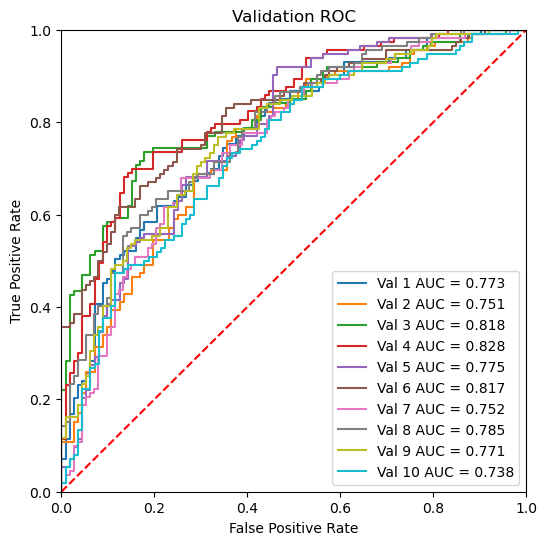

In [41]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

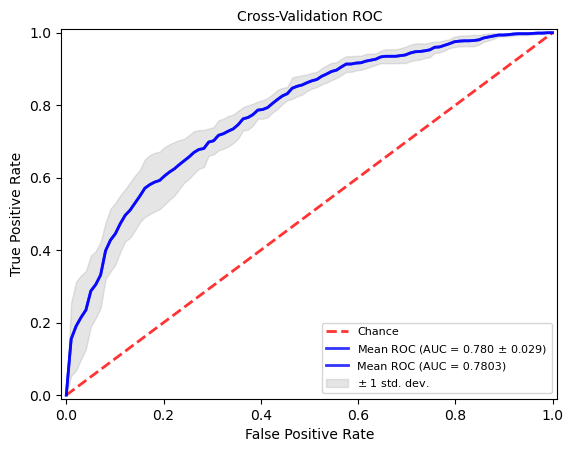

In [42]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [43]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [44]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [45]:
my_calculate_metrics_list_val

[{'SN': 0.8938053097345132,
  'SP': 0.42857142857142855,
  'ACC': 0.6622222222222223,
  'MCC': 0.3644973143252602,
  'Recall': 0.8938053097345132,
  'Precision': 0.6121212121212121,
  'F1-score': 0.7266187050359713,
  'Cutoff': 0.5},
 {'SN': 0.8928571428571429,
  'SP': 0.4732142857142857,
  'ACC': 0.6830357142857143,
  'MCC': 0.4033003660954137,
  'Recall': 0.8928571428571429,
  'Precision': 0.6289308176100629,
  'F1-score': 0.7380073800738007,
  'Cutoff': 0.5},
 {'SN': 0.7433628318584071,
  'SP': 0.7232142857142857,
  'ACC': 0.7333333333333333,
  'MCC': 0.4666877551549868,
  'Recall': 0.7433628318584071,
  'Precision': 0.7304347826086957,
  'F1-score': 0.7368421052631579,
  'Cutoff': 0.5},
 {'SN': 0.8230088495575221,
  'SP': 0.5982142857142857,
  'ACC': 0.7111111111111111,
  'MCC': 0.4324752714483147,
  'Recall': 0.8230088495575221,
  'Precision': 0.6739130434782609,
  'F1-score': 0.7410358565737052,
  'Cutoff': 0.5},
 {'SN': 0.8141592920353983,
  'SP': 0.5446428571428571,
  'ACC': 0.

In [46]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.893805,0.428571,0.662222,0.364497,0.893805,0.612121,0.726619,0.5
1,0.892857,0.473214,0.683036,0.403300,0.892857,0.628931,0.738007,0.5
2,0.743363,0.723214,0.733333,0.466688,0.743363,0.730435,0.736842,0.5
3,0.823009,0.598214,0.711111,0.432475,0.823009,0.673913,0.741036,0.5
4,0.814159,0.544643,0.680000,0.372759,0.814159,0.643357,0.718750,0.5
5,0.883929,0.469027,0.675556,0.387612,0.883929,0.622642,0.730627,0.5
6,0.776786,0.601770,0.688889,0.384370,0.776786,0.659091,0.713115,0.5
7,0.687500,0.681416,0.684444,0.368916,0.687500,0.681416,0.684444,0.5
8,0.544643,0.823009,0.684444,0.382967,0.544643,0.753086,0.632124,0.5
9,0.803571,0.553571,0.678571,0.368856,0.803571,0.642857,0.714286,0.5


In [47]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.893805,0.428571,0.662222,0.364497,0.893805,0.612121,0.726619,0.5
1,0.892857,0.473214,0.683036,0.403300,0.892857,0.628931,0.738007,0.5
2,0.743363,0.723214,0.733333,0.466688,0.743363,0.730435,0.736842,0.5
3,0.823009,0.598214,0.711111,0.432475,0.823009,0.673913,0.741036,0.5
4,0.814159,0.544643,0.680000,0.372759,0.814159,0.643357,0.718750,0.5
5,0.883929,0.469027,0.675556,0.387612,0.883929,0.622642,0.730627,0.5
6,0.776786,0.601770,0.688889,0.384370,0.776786,0.659091,0.713115,0.5
7,0.687500,0.681416,0.684444,0.368916,0.687500,0.681416,0.684444,0.5
8,0.544643,0.823009,0.684444,0.382967,0.544643,0.753086,0.632124,0.5
9,0.803571,0.553571,0.678571,0.368856,0.803571,0.642857,0.714286,0.5


In [48]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [49]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [50]:
roc_auc_list_indep

[0.7767059948979592,
 0.7798150510204082,
 0.7923309948979592,
 0.7578922193877551,
 0.7942442602040816,
 0.7565369897959184,
 0.7916135204081632,
 0.796875,
 0.7818080357142857,
 0.7849170918367346]

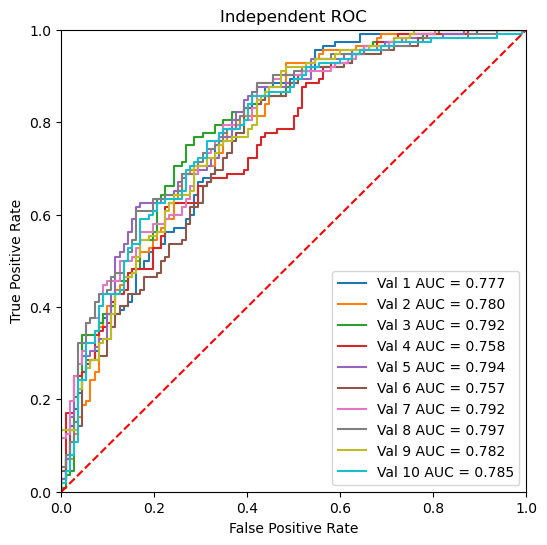

In [51]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

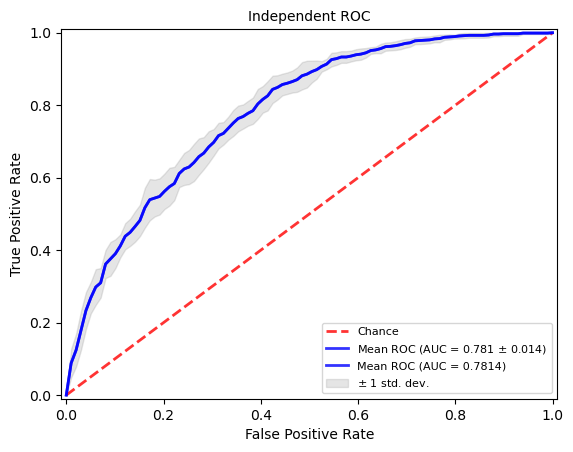

In [52]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [53]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [54]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [55]:
my_calculate_metrics_list_indep

[{'SN': 0.9017857142857143,
  'SP': 0.48214285714285715,
  'ACC': 0.6919642857142857,
  'MCC': 0.4229735546854339,
  'Recall': 0.9017857142857143,
  'Precision': 0.6352201257861635,
  'F1-score': 0.7453874538745388,
  'Cutoff': 0.5},
 {'SN': 0.9285714285714286,
  'SP': 0.4732142857142857,
  'ACC': 0.7008928571428571,
  'MCC': 0.45128800886082376,
  'Recall': 0.9285714285714286,
  'Precision': 0.6380368098159509,
  'F1-score': 0.7563636363636363,
  'Cutoff': 0.5},
 {'SN': 0.7232142857142857,
  'SP': 0.7321428571428571,
  'ACC': 0.7276785714285714,
  'MCC': 0.4553752943387381,
  'Recall': 0.7232142857142857,
  'Precision': 0.7297297297297297,
  'F1-score': 0.726457399103139,
  'Cutoff': 0.5},
 {'SN': 0.7767857142857143,
  'SP': 0.5446428571428571,
  'ACC': 0.6607142857142857,
  'MCC': 0.3304560687093142,
  'Recall': 0.7767857142857143,
  'Precision': 0.6304347826086957,
  'F1-score': 0.696,
  'Cutoff': 0.5},
 {'SN': 0.8214285714285714,
  'SP': 0.625,
  'ACC': 0.7232142857142857,
  'MCC':

In [56]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.901786,0.482143,0.691964,0.422974,0.901786,0.635220,0.745387,0.5
1,0.928571,0.473214,0.700893,0.451288,0.928571,0.638037,0.756364,0.5
2,0.723214,0.732143,0.727679,0.455375,0.723214,0.729730,0.726457,0.5
3,0.776786,0.544643,0.660714,0.330456,0.776786,0.630435,0.696000,0.5
4,0.821429,0.625000,0.723214,0.455299,0.821429,0.686567,0.747967,0.5
5,0.910714,0.482143,0.696429,0.434813,0.910714,0.637500,0.750000,0.5
6,0.741071,0.678571,0.709821,0.420465,0.741071,0.697479,0.718615,0.5
7,0.642857,0.750000,0.696429,0.395132,0.642857,0.720000,0.679245,0.5
8,0.500000,0.839286,0.669643,0.360680,0.500000,0.756757,0.602151,0.5
9,0.839286,0.589286,0.714286,0.442627,0.839286,0.671429,0.746032,0.5


In [57]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.901786,0.482143,0.691964,0.422974,0.901786,0.635220,0.745387,0.5
1,0.928571,0.473214,0.700893,0.451288,0.928571,0.638037,0.756364,0.5
2,0.723214,0.732143,0.727679,0.455375,0.723214,0.729730,0.726457,0.5
3,0.776786,0.544643,0.660714,0.330456,0.776786,0.630435,0.696000,0.5
4,0.821429,0.625000,0.723214,0.455299,0.821429,0.686567,0.747967,0.5
5,0.910714,0.482143,0.696429,0.434813,0.910714,0.637500,0.750000,0.5
6,0.741071,0.678571,0.709821,0.420465,0.741071,0.697479,0.718615,0.5
7,0.642857,0.750000,0.696429,0.395132,0.642857,0.720000,0.679245,0.5
8,0.500000,0.839286,0.669643,0.360680,0.500000,0.756757,0.602151,0.5
9,0.839286,0.589286,0.714286,0.442627,0.839286,0.671429,0.746032,0.5


In [58]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_UbidelAcet\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

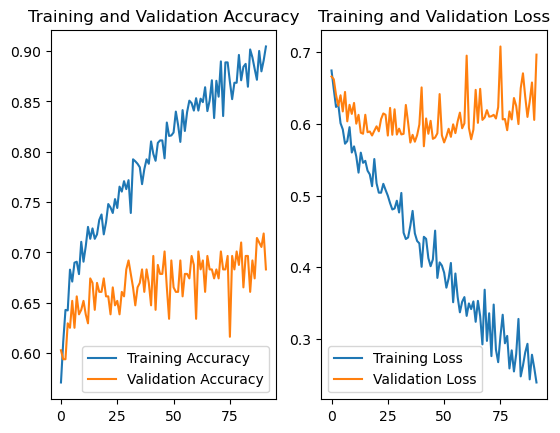

In [60]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()